In [11]:
import torch
import ipdb
import numpy as np
import pandas as pd
from scipy.stats import entropy
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as utils
from sbi import analysis as analysis
from tqdm import tqdm
import ssms

In [140]:
#ssms.config.model_config

In [2]:
model = 'levy'
out = ssms.basic_simulators.simulator(theta = ssms.config.model_config[model]['default_params'], 
                                model = model, n_samples = 1000)

In [3]:
num_dim = 4
priorUnif = utils.BoxUniform(low=[-3.0, 0.3, 0.1, 0.0], high=[3.0, 2.5, 0.9, 2.0])

In [4]:
#assuming fixing theta at 0.5
def simulator(parameter_set, bins):
    fullParams = torch.cat((parameter_set, torch.tensor([0.5])),0)
    #Call a basic simulator
    x = ssms.basic_simulators.simulator(theta = fullParams, n_samples = 1000)
    #Extract the rts and choice into a tuple
    tupleCouple = (x['rts'], x['choices'])
    #Turn tuple into np array
    data = np.transpose(np.squeeze(np.array(tupleCouple)))
    bins = np.linspace(-10.0,10.0,130)


    onesBool = data[:,1] == 1
    oneArray = data[:,0][onesBool]
    minusOnesBool = data[:,1] == -1
    minusOneArray = np.multiply(data[:,0][minusOnesBool], -1)
    fullArray = np.append(oneArray, minusOneArray)
    histy = np.histogram(fullArray, bins=bins, density = True)
    return histy[0]

In [84]:
np.multiply(ssms.basic_simulators.simulator(theta = torch.tensor([0, 1, 0.5, 1, 0.5]), n_samples = 5)['rts'], -1)

array([[-2.134997 ],
       [-1.7229943],
       [-1.4669975],
       [-1.2490003],
       [-1.4259981]], dtype=float32)

In [5]:
def simforPosterior(parameter_set, bins):
    rtArray = np.zeros(0)
    choiceArray = np.zeros(0)
    for i in parameter_set:
        fullParams = torch.cat((i, torch.tensor([0.5])),0)
        x = ssms.basic_simulators.simulator(theta = fullParams, n_samples = 5)
        rtArray = np.append(rtArray, x['rts'])
        choiceArray = np.append(choiceArray, x['choices'])
    tupleCouple = (rtArray, choiceArray)
    data = np.transpose(np.squeeze(np.array(tupleCouple)))


    onesBool = data[:,1] == 1
    oneArray = data[:,0][onesBool]
    minusOnesBool = data[:,1] == -1
    minusOneArray = np.multiply(data[:,0][minusOnesBool], -1)
    fullArray = np.append(oneArray, minusOneArray)
    histy = np.histogram(fullArray, bins=bins, density = True)
    return histy[0]

In [109]:
samples[:,3]

tensor([1.0682, 0.9936, 1.0403,  ..., 1.0385, 1.0135, 1.0690])

In [6]:
def linear_gaussian(theta):
    return theta + 1.0 + torch.randn_like(theta) * 0.1

In [8]:
simulator, prior = prepare_for_sbi(simulator, priorUnif)

TypeError: simulator() missing 1 required positional argument: 'bins'

In [112]:
inference = SNPE(prior=priorUnif)

In [ ]:
theta, x = simulate_for_sbi(simulator, proposal=priorUnif, num_simulations=1000)

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

TypeError: simulator() missing 1 required positional argument: 'bins'

In [34]:
x

tensor([[  0.,   0.,   0.,  ...,   0.,   0.,   0.],
        [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
        [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
        [  0.,  32., 139.,  ...,   0.,   0.,   0.],
        [  0.,   0.,   0.,  ...,   0.,   0.,   0.]])

In [10]:
inference = inference.append_simulations(theta, x)

NameError: name 'inference' is not defined

In [115]:
density_estimator = inference.train()

Neural network successfully converged after 152 epochs.


In [116]:
#torch.device = 'cpu'
posterior = inference.build_posterior(density_estimator)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

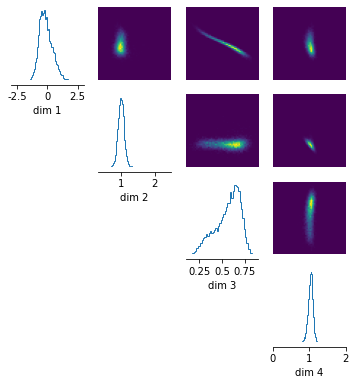

In [119]:
observation = simulator(torch.tensor([0, 1, 0.5, 1]))
samples = posterior.sample((10000,), x=observation)
log_probability = posterior.log_prob(samples, x=observation)
#low=[-3.0, 0.3, 0.1, 0.0, 0.5], high=[3.0, 2.5, 0.9, 2.0, 0.5]
_ = analysis.pairplot(samples, limits=[[-3,3],[.3,2.5],[.1,.9], [0.0,2.0]], figsize=(6,6))

In [59]:
samples

tensor([[-0.1264,  0.9092,  0.5637,  1.0682],
        [ 0.0745,  1.0006,  0.5548,  0.9936],
        [ 0.1950,  0.9031,  0.4587,  1.0403],
        ...,
        [ 0.1173,  0.8816,  0.4985,  1.0385],
        [-0.6403,  0.9550,  0.6872,  1.0135],
        [-0.0024,  0.9786,  0.5078,  1.0690]])

In [124]:
##POSTERIOR STUFF
binObject = np.linspace(0.0,10.0,65)
bigArray = np.zeros(0)
bigArray2 = np.zeros(0)
# for i in theta:
#     bigArray = np.append(bigArray,simforPosterior(i))
# kl1=np.histogram(bigArray, bins = 30, density = True)   

# for i in samples:
#     bigArray2 = np.append(bigArray2, simforPosterior(i))
# kl2=np.histogram(bigArray2, bins = binObject, density = True)
kl2 = simforPosterior(parameter_set = samples)

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.00000000e+00, 8.20000000e+01,
       1.02000000e+02, 1.08000000e+02, 8.20000000e+01, 7.80000000e+01,
       3.60000000e+01, 2.50000000e+01, 1.00000000e+01, 3.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [60]:
simforPosterior(torch.tensor([0, 1, 0.5, 1]))

array([ 1.46299756,  1.35999894, -1.18000019, -1.36999881, -1.8139931 ])

In [121]:

def kl(p, q):
    """Kullback-Leibler divergence D(P || Q) for discrete distributions
    Parameters
    ----------
    p, q : array-like, dtype=float, shape=n
    Discrete probability distributions.
    """
    p = np.asarray(p, dtype=np.float)
    q = np.asarray(q, dtype=np.float)

    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

In [125]:
kl(observation, kl2)

/users/avo2/miniconda3/envs/debugsbi2/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/users/avo2/miniconda3/envs/debugsbi2/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':
/users/avo2/miniconda3/envs/debugsbi2/

0.19082637750376097

In [127]:
for i in np.arange(50, 200, 5):
    bins = np.linspace(-10.0,10.0, i)
    
    

array([ 50,  55,  60,  65,  70,  75,  80,  85,  90,  95, 100, 105, 110,
       115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175,
       180, 185, 190, 195])

In [105]:
kl1[0]

array([0.00126045, 0.00378136, 0.00756273, 0.01008364, 0.02016728,
       0.04159501, 0.07184593, 0.09705503, 0.19411005, 0.24704916,
       0.23066325, 0.23570507, 0.22688188, 0.14999413, 0.06050184,
       0.01890682, 0.10839912, 0.14999413, 0.19537051, 0.26091416,
       0.23066325, 0.18150551, 0.15755686, 0.09201321, 0.06806456,
       0.04033456, 0.01764637, 0.013865  , 0.01260455, 0.00504182])